In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

For our summarization task we would use our second dataset that contains 134010 lines.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df1 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG01.json')
df2 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG02.json')
df3 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG03.json')
df4 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG04.json')
df5 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG05.json')
df6 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG06.json')
df7 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG07.json')

In [5]:
full_data = pd.concat([df1, df2, df3, df4, df5, df6, df7])
print("Total lines in base dataframe:", len(full_data))
print("Total duplicated lines:", len(full_data[full_data.duplicated(keep='first')]))
df = full_data.drop_duplicates()
print("Total unique lines in cleaned dataframe:", len(df))

Total lines in base dataframe: 134010
Total duplicated lines: 16
Total unique lines in cleaned dataframe: 133994


Let's have a first look at our data common stats.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133994 entries, 0 to 19136
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Article_id     133994 non-null  int64 
 1   Url            133994 non-null  object
 2   Date_time      133994 non-null  object
 3   Head_rubric    130537 non-null  object
 4   Head_title     133857 non-null  object
 5   Head_subtitle  29880 non-null   object
 6   Text           133889 non-null  object
 7   Keywords       133509 non-null  object
 8   Authors        133509 non-null  object
dtypes: int64(1), object(8)
memory usage: 10.2+ MB


At first we have 105 Null cells in Text column in dataframe that was not collected automatically due to specific of html and css formatting of some special news pages. And secondly we see 137 empty cells which must contain news titles. Let's get only lines that are full of texts.

In [0]:
df = df[df['Text'].notna()]
df = df[df['Head_title'].notna()]
df = df.reset_index(drop=True)

Drop some unusefull columns.

In [0]:
df = df.drop(['Article_id', 'Url', 'Head_subtitle', 'Authors'], axis=1)

Check the number of characters in the text of the news for each line.

In [0]:
df['Text'] = df['Text'].str.strip()
df['Text_count_signs'] = df['Text'].str.len()

In [10]:
df.nsmallest(5, 'Text_count_signs')

,Date_time,Head_rubric,Head_title,Text,Keywords,Text_count_signs
13997,2018-01-07T17:50:00,Культура,Чулпан Хаматова читает стихотворение Пастернак...,,"Культура, Литература, РГ-Видео",0
46537,2020-02-28T16:50:00,Общество,"Карточки, мешочники, спекулянты",,"Общество, История, ""Родина"", Новости, СССР, Ве...",0
48747,2020-01-10T21:25:00,Общество,"Россия 2010-х: криптовалюта, новый стиль и сос...",,"Общество, История, ""Родина"", Новости, Россия, ...",0
49180,2019-12-26T23:39:00,Общество,Где смотреть и как не опоздать,,"Общество, Ежедневник, Праздники, Филиалы РГ, С...",0
49220,2019-12-26T14:15:00,Общество,Переименованная Москва,,"Общество, История, ""Родина"", Новости, Москва, ...",0


Some site pages did not contain news information in text form, but was presented by infographics or youtube videos. From this pages were collected only copyright data, that unuseful for our task. All of this data items were checked manually. For these reasons, we can remove from the dataset all rows with the Text_count_signs value less than 100.

In [11]:
df = df[df['Text_count_signs'] > 100]
df = df.reset_index(drop=True)
print("Total unique lines in final dataframe:", len(df))

Total unique lines in final dataframe: 133805


Now check our headers with same method.

In [0]:
df['Head_title'] = df['Head_title'].str.strip()
df['Title_count_signs'] = df['Head_title'].str.len()

In [13]:
df.nsmallest(5, 'Title_count_signs')

,Date_time,Head_rubric,Head_title,Text,Keywords,Text_count_signs,Title_count_signs
31920,2018-06-14T23:58:00,Спорт,5+!,"Этого дня все мы ждали восемь лет - с тех пор,...","Спорт, Футбол, Чемпионат мира, Чемпионат мира ...",11090,3
39539,2019-08-20T19:50:00,None,БКД,"Начинается земля,как известно, от Кремля. Н...","Общество, История, Культура, Арт, Архитектура,...",3165,3
47322,2020-02-10T20:26:00,Общество,296,Этот день отмечается как День российской науки...,"Общество, Наука, Колонка Леонида Радзиховского",5462,3
10276,2018-09-27T00:00:00,Культура,Ключ,С одним из больших и пока ещё практически неиз...,"Культура, Литература",8143,4
12169,2018-05-23T20:05:00,Культура,Свет,"Случай в Тильской галерееО том, что произошло ...","Культура, Литература",12205,4


We haven't got empty headers. The shortest headers is make sense. For example "five plus" is highest rate in russian grading system in schools. The 296 num seems the number of the day of the year, when the described holiday comes, etc.

In [0]:
df = df.sort_values('Date_time')

We sort our data for DateTime. Now we have 603 lines that contains "0001-01-01T00:00:00" DateTime value. This happened during parsing process, when some news hadn't got any time stamps. Min value DateTime was automatically added. These lines represent only 0.5% of the total data set, save them too.

After all for our summarization task we don't need any column except "Text" that to be used as inputs and "Head_title" that to be used as targets.

But first, let's collect some statistics on the dataset for its analysis. To do this, we remove the columns that no longer provide us with useful information.

In [0]:
df = df.drop(['Date_time', 'Text_count_signs', 'Title_count_signs'], axis=1)
df = df.reset_index(drop=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133805 entries, 0 to 133804
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Head_rubric  130486 non-null  object
 1   Head_title   133805 non-null  object
 2   Text         133805 non-null  object
 3   Keywords     133323 non-null  object
dtypes: object(4)
memory usage: 4.1+ MB


Define some utils functions.

In [0]:
def get_rubrics_stat(dataset):
    unique_rubrics = dataset.Head_rubric.unique()
    print("Total rubrics:", len(unique_rubrics))
    rubrics = {}
    for item in unique_rubrics:
        if item is None:
            rubrics[item] = len(dataset[dataset["Head_rubric"].isna()])
            continue
        rubrics[item] = len(dataset[dataset["Head_rubric"] == item])
    return rubrics

    
def show_rubrics_stat(rubrics):    
    sorted_r = {k: v for k, v in sorted(rubrics.items(), key=lambda item: item[1], reverse=True)}
    for k, v in sorted_r.items():
        print("%s: %s" % (k, v))


def replace_minor_headrubrics(dataset, stats, threshold):
    major = []
    minor = []
    for key, val in stats.items():
        if val > threshold:
            major.append(key)
        else:
            minor.append(key)
    for name in minor:
        temp = dataset[dataset['Head_rubric'] == name]
        new = None
        flag = False
        for _, row in temp.iterrows():
            if row['Keywords'] is None:
                continue
            keywords = [x.strip() for x in row['Keywords'].split(',')]
            for item in keywords:
                if item in major:
                    new = item
                    flag = True
                    break
            if flag: break
        dataset.Head_rubric[dataset.Head_rubric == name] = new


def relabel_empty_headrubrics(dataset, stats):
    head_rubrics = [x for x in stats.keys() if x is not None]
    for index, row in dataset.iterrows():
        if row['Head_rubric'] is None:
            if row['Keywords'] is None:
                continue
            keywords = [x.strip() for x in row['Keywords'].split(',')]
            for item in keywords:
                if item in head_rubrics:
                    row['Head_rubric'] = item
                    continue

In [18]:
hr_stat = get_rubrics_stat(df)
show_rubrics_stat(hr_stat)

Total rubrics: 78
Спорт: 20550
Происшествия: 20122
В мире: 18583
Власть: 18524
Общество: 18281
Культура: 17079
Экономика: 16865
None: 3319
Бензин: 66
Транспорт: 51
Внутренняя политика: 39
Работа власти: 28
ДТП: 27
Транспортное право: 23
Административное право: 19
Общественный транспорт: 19
Инфраструктура: 18
Промышленность: 14
Госуправление: 12
Товары и цены: 11
Безопасность: 10
Долги и кредиты: 9
Налоги: 9
Охрана порядка: 8
Страхование: 7
Суд: 6
Криминал: 6
Образ жизни: 6
Регионы: 5
Право: 5
Крупные компании: 5
Германия: 5
Легковые авто: 5
Уголовное право: 4
Аукционы и коллекции: 3
Внешняя политика: 3
Правоохранительная система: 3
Япония: 3
США: 3
Социология: 3
Позиция: 2
Личные документы: 2
Актуальное искусство: 2
Нефть и газ: 2
Туризм: 2
Соцсфера: 2
Наука: 2
Гражданское право: 2
Дороги: 2
Кино и ТВ: 1
Игроки и тренеры: 1
Литература: 1
Земля: 1
Жилищное право: 1
Железные дороги: 1
ТВ и сериалы: 1
ЖКХ: 1
Банки: 1
Живопись: 1
Правосудие: 1
Бразилия: 1
ЧП: 1
Великобритания: 1
Образовани

With 7 basic news categories we are also have specialized labels, which are represented with only a few texts. Max count for one kind of minor category is 66 texts. We relabel this texts by a suitable tag from the Keywords list, that include basic categories tags.

In [0]:
replace_minor_headrubrics(df, hr_stat, threshold=66)

In [20]:
hr_stat = get_rubrics_stat(df)
show_rubrics_stat(hr_stat)

Total rubrics: 8
Спорт: 20551
Происшествия: 20171
Власть: 18688
В мире: 18600
Общество: 18300
Культура: 17089
Экономика: 17087
None: 3319


After relabeling we have got 3319 texts without category at all. Relabel them with same way.

In [0]:
relabel_empty_headrubrics(df, hr_stat)

In [22]:
show_rubrics_stat(get_rubrics_stat(df))

Total rubrics: 8
Спорт: 20558
Происшествия: 20227
Власть: 19083
В мире: 18786
Общество: 18559
Культура: 18408
Экономика: 18183
None: 1


Now we have just one unmarked text with an empty Keywords list. Have a look what kind of news is this.

In [23]:
df[df['Head_rubric'].isna()]

,Head_rubric,Head_title,Text,Keywords
71,None,Декрет Высшего Государственного Совета Союзног...,Принят Парламентским Собранием Союза Беларуси ...,None


This is the Belarusian legislative act. Absolutely formal publication, without any reflection of events that happened, etc. Actually not a news. Drop it easily. We also drop a several dataset invalid items after manual checking. This save for you a dozens of hours of debugging models.

In [0]:
df.drop([71, 12770, 36990, 37257, 38290, 45594, 46151, 61751, 65388, 67493, 68065,
         75284, 76211, 77700, 78495, 83602, 88017, 91290, 91405, 92096, 92127, 93932,
         97049, 98278, 99318, 99414, 110913, 113232, 118183, 125802, 132608, 133102], inplace=True)
df.drop(['Keywords'], axis=1, inplace=True)
cleaned_dataset = df.reset_index(drop=True)

Some next lines may looks weird, but it make sense. Order of this pipeline is strictly defined. Replacing several regular expressions with one complex expression in a single procedure gives you a different result. 

In [ ]:
cleaned_dataset['Text'] = cleaned_dataset['Text'].str.replace('(?<=[.!?…])(?=[А-Я])', ' ', case=True)
cleaned_dataset['Text'] = cleaned_dataset['Text'].str.replace('(?<=[!?…])(?=[A-Z])', ' ', case=True)
cleaned_dataset['Text'] = cleaned_dataset['Text'].str.replace('(?<=[а-я])(?=[А-Я])', '. ', case=True)
cleaned_dataset['Text'] = cleaned_dataset['Text'].str.replace('CоV', 'CoV', case=True)
cleaned_dataset['Text'] = cleaned_dataset['Text'].str.replace('(?<=[а-я])(?=[A-Z])', '. ', case=True)
cleaned_dataset['Text'] = cleaned_dataset['Text'].str.replace('(?<=[a-z])(?=[А-Я])', '. ', case=True)

In [25]:
cleaned_dataset.head()

,Head_rubric,Head_title,Text
0,Экономика,"Эксперты выяснили, кто в России чаще всего бер...",Руководители высшего звена предприятия или учр...
1,Экономика,"""Пятый канал"" сохраняет лидерство по среднесут...","По данным Mediascope на конец 2019 года, канал..."
2,Экономика,Ставки вниз: сколько будут стоить кредиты в 20...,"Аналитики полагают, что в первом полугодии 202..."
3,Экономика,Где отдыхали россияне в 2019 году,"""В 2019 году Крым принял 7 миллионов отдыхающи..."
4,Экономика,В 2020 году может вернуться инвестиционный спр...,"""В прогнозах на 2019 год всех пугали сильным р..."


In [26]:
!pip install --upgrade razdel pymorphy2

     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 7.1MB 25.7MB/s 


Let's count statistics by words.

In [0]:
from collections import Counter, namedtuple
import razdel
import pymorphy2

USEFUL_POS = ['NOUN', 'ADJF', 'ADJS', 'COMP',
              'VERB', 'INFN', 'PRTF', 'PRTS', 
              'GRND', 'ADVB', 'NPRO', 'PRED']

Stats = namedtuple("Stats", "vocabulary, lemma_vocabulary, words_counts, unique_words_counts")

Define some utils functions.

In [0]:
def collect_statistics(data, max_words):
    pm = pymorphy2.MorphAnalyzer()
    stats = Stats(Counter(),  Counter(), list(), list())
    for text in data:
        process_text(text, stats, max_words, pm)
    return stats


def process_text(text, text_stats, max_words, analyzer):
    words = [word.text for word in razdel.tokenize(text)][:max_words]
    lemmas = [analyzer.parse(word)[0] for word in words]
    lemmas = [lemma for lemma in lemmas if lemma.tag.POS in USEFUL_POS]
    words = [lemma.word for lemma in lemmas]
    lemmas = [lemma.normal_form for lemma in lemmas]
    text_stats.vocabulary.update(words)
    text_stats.lemma_vocabulary.update(lemmas)
    text_stats.words_counts.append(len(words))
    text_stats.unique_words_counts.append(len(set(words)))


def draw_stat_hists(data, bins=10, label=None):
    words = data.words_counts
    uwords = data.unique_words_counts
    if label is not None:
        label = " in single " + label
    else:
        label = ""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    ax1.hist(words, bins)
    ax1.set_title("Words" + label)
    ax1.set_xlabel("Num of words")
    ax1.set_ylabel("Examples")
    ax2.hist(uwords, bins)
    ax2.set_title("Unique words" + label)
    ax2.set_xlabel("Num of words")
    ax2.set_ylabel("Examples")
    plt.show()

We collect statistics for a quarter of our dataset, taking these examples with a uniform distribution. We assume that so many examples will be enough to extrapolate the obtained statistics to the full dataset.

In [0]:
np.random.seed(13)
examples = 30000
indices = np.random.randint(len(cleaned_dataset), size=examples)
text_data = cleaned_dataset['Text'].values[indices]
header_data = cleaned_dataset['Head_title'].values[indices]

In [30]:
%%time
text_stats = collect_statistics(text_data, max_words=3000)
header_stats = collect_statistics(header_data, max_words=3000)

CPU times: user 34min 43s, sys: 498 ms, total: 34min 43s
Wall time: 34min 45s


In [31]:
print("Texts vocabulary size: ", len(text_stats.vocabulary))
print("Texts lemma vocabulary size: ", len(text_stats.lemma_vocabulary))
print("Headers vocabulary size: ", len(header_stats.vocabulary))
print("Headers lemma vocabulary size: ", len(header_stats.lemma_vocabulary))
print("Common lemmas headers vs texts: ", len(set(header_stats.lemma_vocabulary.keys()) & set(text_stats.lemma_vocabulary.keys())))

Texts vocabulary size:  340264
Texts lemma vocabulary size:  148757
Headers vocabulary size:  37760
Headers lemma vocabulary size:  18595
Common lemmas headers vs texts:  18198


In [32]:
text_stats.lemma_vocabulary.most_common(10)

[('быть', 80059),
 ('он', 64909),
 ('год', 57773),
 ('который', 50588),
 ('весь', 40861),
 ('они', 38217),
 ('один', 37071),
 ('тот', 34600),
 ('мы', 31425),
 ('это', 30410)]

In [33]:
header_stats.lemma_vocabulary.most_common(10)

[('россия', 1285),
 ('москва', 905),
 ('коронавирус', 786),
 ('путин', 766),
 ('человек', 754),
 ('год', 748),
 ('сша', 711),
 ('назвать', 688),
 ('быть', 607),
 ('один', 592)]

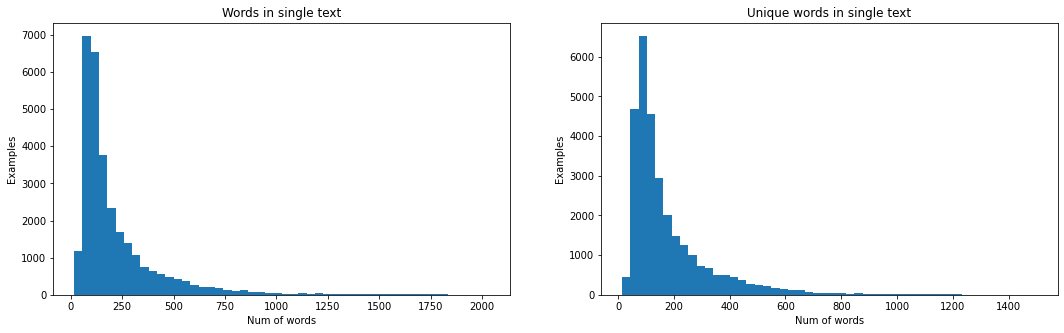

In [34]:
draw_stat_hists(text_stats, 50, label='text')

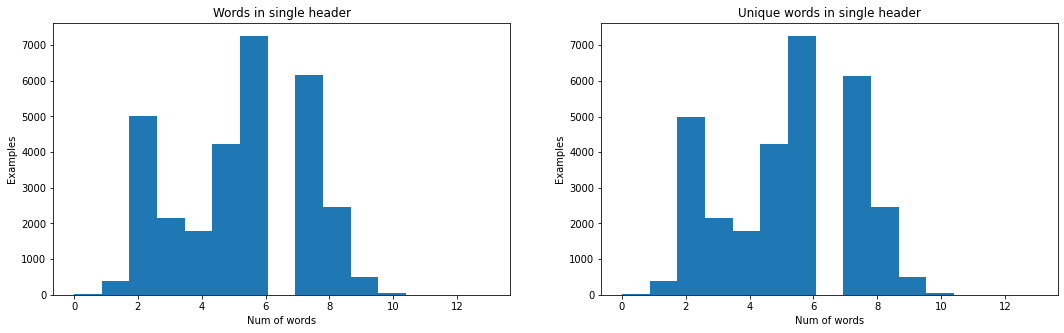

In [35]:
draw_stat_hists(header_stats, 15, label='header')